In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scipy.interpolate as intp

df = pd.read_csv('mnist_test.csv').sort_values(by=['7']).reset_index().drop(['index'],axis=1)
ar = df['7'].to_numpy()
counts = np.zeros(11)
for i in range(10):
    counts[i+1] =  counts[i] + ar[ar == i].shape[0]
    
def mnist_instance(df,counts,rng,i):
    #generates an OT instance corresponding to two randomly chosen digits from MNIST with label i
    n = 28
    x1 = rng.integers(counts[i],counts[i+1])
    x2 = rng.integers(counts[i],counts[i+1])
    p = df.iloc[x1,1:].to_numpy() + 1/(n**2); p = p/p.sum()
    q = df.iloc[x2,1:].to_numpy() + 1/(n**2); q = q/q.sum()
    b = np.append(p,q)
    C = np.zeros((n**2,n**2))
    for i1 in range(n):
        for i2 in range(n):
            for j1 in range(n):
                for j2 in range(n):
                    C[n*i1+i2,n*j1+j2] = (i1-j1)**2 + (i2-j2)**2
    return b, (C/C.max()).reshape(-1,1).squeeze()

In [2]:
def mult_A(x):
    #computes Ax
    n = len(x)
    k = int(np.sqrt(n))
    return np.append(x.reshape(k,k).sum(axis=0),x.reshape(k,k).sum(axis=1))

def mult_AT(y):
    #computes A^T y
    q = len(y)
    k = q//2
    a = y[:k].reshape(1,-1)
    b = y[k:].reshape(-1,1)
    return (a + b).reshape(-1,1).squeeze()

#the function: C^T X +  y^T [AX - b]
def grad_x(b,C,x,y):
    return C + (mult_AT(y))

def grad_y(b,C,x,y):
    return (b - mult_A(x))

def alt_x(b,C,d_x,w_y,entropy_factor):
    z = w_y**2
    q = -(mult_AT(z) + d_x)/entropy_factor
    scale = np.max(q)
    q = q - scale*np.ones(len(q))
    x = np.exp(q)
    return x/np.sum(x) #has to lie on simplex 

def alt_y(b,C,d_y,w_x):
    y = np.zeros(len(d_y))
    v = mult_A(w_x)
    for i in range(len(d_y)):
        signing = np.sign(d_y[i])*np.sign(v[i])
        if abs(2*v[i]) > abs(d_y[i]):
            y[i] = -signing*d_y[i]/(2*v[i])
        elif signing == 1:
            y[i] = -1
        else:
            y[i] = 0
        if y[i] > 0:
            println("Positive y")
    return y

#computes the regularizer gradient
def grad_r(x,y,entropy_factor):
    z = y**2
    gr_x = (mult_AT(z)) + entropy_factor*np.log(x)
    gr_y = 2*(y*(mult_A(x)))
    return gr_x, gr_y

def prox(b,C,z_x,z_y,g_x,g_y,entropy_factor,tol):
    out_x, out_y = z_x, z_y
    v = out_y
    zgrad_x = grad_r(z_x,z_y,entropy_factor)[0]
    zgrad_y = grad_r(z_x,z_y,entropy_factor)[1]
    d_x = g_x - zgrad_x
    d_y = g_y - zgrad_y
    out_x = alt_x(b,C,d_x,out_y,entropy_factor)
    alt_steps = 1
    while True:
        out_y = alt_y(b,C,d_y,out_x)
        v = alt_x(b,C,d_x,out_y,entropy_factor)
        alt_steps += 1
        if la.norm(v-out_x,1) < tol:
            return v, out_y, alt_steps
        if alt_steps > 100:
            println("Prox failure")
        out_x = v

In [3]:
def sherman_prox(n,b,C,T,L):
    alt_steps = []
    progress = []
    z_x = np.ones(n**2)/(n**2)
    z_y = np.zeros(2*n)
    w_x = np.zeros(n**2)/(n**2)
    w_y = np.zeros(2*n)
    counter = 0
    minval = 1e2
    out_x = w_x 
    i = 0
    out_y = w_y
    while counter < T:
        g_x = grad_x(b,C,z_x,z_y)
        g_y = grad_y(b,C,z_x,z_y)
        counter += 1
        tol = 5e2/(i+1)**2
        w_x, w_y, d = prox(b,C,z_x,z_y,g_x,g_y,L,tol) 
        counter += d
        g_x = grad_x(b,C,w_x,w_y)
        g_y = grad_y(b,C,w_x,w_y)
        counter += 1
        z_x, z_y, d = prox(b,C,z_x,z_y,g_x,g_y,L,tol)
        counter += d
        if i%10 == 0:
            clear_output(wait=True)
            print("Completed ", i, " steps")
            print("Alternating Steps:", counter)
            progress.append(np.dot(C,w_x) + la.norm(mult_A(w_x)- b,1))
            alt_steps.append(counter)
            print("Current Value: ", progress[-1])
        i += 1
    return alt_steps, progress

In [4]:
#NEW:
def mult_A2(x):
    return np.append(x.T@np.ones(n), x@np.ones(n))

def clip(x):
    #returns x, clipped to be between -1 and 1
    for idx in range(len(x)):
        if x[idx] > 1:
            x[idx] = 1
        elif x[idx] < -1:
            x[idx] = -1
    return x


def mult_AT2(y):
    #computes A^T y
    q = len(y)
    k = q//2
    a = y[:k].reshape(1,-1)
    b = y[k:].reshape(-1,1)
    return (a + b)

def prox_full_transportmap(b,C,xbar,ybar,alpha,tol,beta):
    x,y = xbar,ybar
    A_xbar = mult_A2(xbar); A_x = A_xbar
    alt_steps = 0
    while True:
        #y[k+1] responds to x[k]
        yp1 = clip((ybar*A_xbar/A_x) + (1-b/A_x)/(2*beta))
        
        #x[k+1] responds to y[k+1]
        d_x = mult_AT2(-yp1-beta*yp1**2 +beta*ybar**2)- C 
        xp1 = xbar*np.exp(d_x); xp1= xp1/xp1.sum()
        A_xp1 = mult_A2(xp1)
        alt_steps += 1
        if la.norm(yp1-y,1) < tol:
            #y'[k+1] responds to x[k+1]
            yp1 = clip((ybar*A_xbar/A_xp1) + (1-b/A_xp1)/(2*beta))
            return xp1, yp1, alt_steps
        if alt_steps > 100:
            raise Exception("Alternating minimization failed to converge")
        #k -> k+1
        x,y,A_x = xp1, yp1, A_xp1
            
def sherman_proxpoint_full_transportmap(n,b,C,T,alpha,beta):
    #this is a version of the algorithm which stores the full transport map every iteration
    z_x = np.ones((n,n))/(n**2)
    z_y = np.zeros(2*n)
    counter = 0
    xbest, ybest = z_x, z_y
    best = 10
    steps = []
    vals = []
    i_disp = display(f"Iteration number: {0}",display_id=True)
    best_disp = display(f"Best marginals: {best}",display_id=True)
    for i in range(T):
        tol = 1e5/(i+1)**2
        i_disp.update(f"Iteration number: {i}")
        z_x, z_y, d = prox_full_transportmap(b,C,z_x,z_y,alpha,tol,beta)
        if i%10 == 0:
            best = np.sum(z_x*C) + la.norm(mult_A2(z_x)-b,1)
            best_disp.update(f"Best marginals: {best}")
            steps.append(counter)
            vals.append(best)
        counter += d
    return steps, vals

In [5]:
q=1
problems = [79543, 893654, 439093, 901514, 892506, 213308, 730353, 857810, 248698, 639250, 941094, 848481, 225911, 438703, 656015, 472702, 464413, 330074, 291973, 67746]
digit = [0, 8, 2, 9, 0, 0, 5, 3, 8, 5, 9, 0, 4, 0, 0, 7, 4, 1, 7, 7]
n = 784;
alpha = 2; beta = 1; T = 2500; 
t = np.linspace(10,T,500)
t_new = np.linspace(10,T,500)
int_fnval = np.zeros((q,500))
new_int_fnval = np.zeros((q,500))
for i in range(q):
    rng = np.random.default_rng(problems[i])
    b, C = mnist_instance(df,counts,rng,digit[i])
    print("New Alg: #", i+1)
    new_steps, new_fnval = sherman_proxpoint_full_transportmap(n,b,C.reshape(784,784),T+150,alpha,beta)
    f = intp.interp1d(new_steps, new_fnval)
    new_int_fnval[i,:] += f(t_new)
    print("Mirror Prox: #", i+1)
    steps,fnval = sherman_prox(n,b,C,T+150,4)
    f = intp.interp1d(steps,fnval)
    int_fnval[i,:]  += f(t)


Completed  440  steps
Alternating Steps: 2646
Current Value:  0.00821647945644056


In [6]:
true_opt=np.zeros([q])
int_fnval_rescaled = np.zeros((q,500))
new_int_fnval_rescaled = np.zeros((q,500))
for i in range(q):
    true_opt[i] = new_int_fnval[i,-1]
    new_int_fnval_rescaled[i,:] = new_int_fnval[i,:]-true_opt[i]
    int_fnval_rescaled[i,:] = int_fnval[i,:]-true_opt[i]

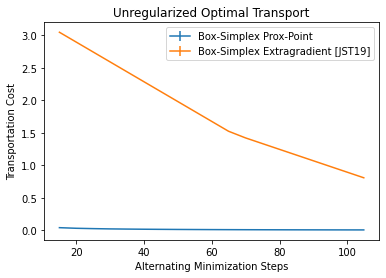

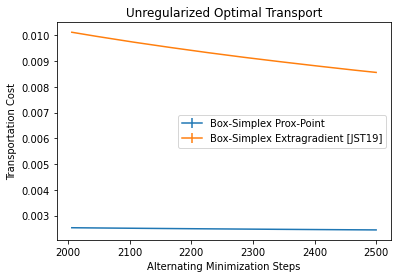

In [7]:
plt.errorbar(t_new[1:20],np.mean(new_int_fnval,axis=0)[1:20],yerr= np.std(new_int_fnval_rescaled,axis=0)[1:20],errorevery = 1)
plt.errorbar(t_new[1:20],np.mean(int_fnval,axis=0)[1:20],yerr= np.std(int_fnval_rescaled,axis=0)[1:20], errorevery = 1)
plt.title("Unregularized Optimal Transport")
plt.legend(["Box-Simplex Prox-Point", "Box-Simplex Extragradient [JST19]"])
plt.xlabel("Alternating Minimization Steps")
plt.ylabel("Transportation Cost")
plt.savefig("noregTC_1_apdx.png",bbox_inches="tight")
plt.show()

plt.errorbar(t_new[400:],np.mean(new_int_fnval,axis=0)[400:],yerr= np.std(new_int_fnval_rescaled,axis=0)[400:], errorevery = 5)
plt.errorbar(t_new[400:],np.mean(int_fnval,axis=0)[400:],yerr= np.std(int_fnval_rescaled,axis=0)[400:], errorevery = 5)
plt.title("Unregularized Optimal Transport")
plt.legend(["Box-Simplex Prox-Point", "Box-Simplex Extragradient [JST19]"])
plt.xlabel("Alternating Minimization Steps")
plt.ylabel("Transportation Cost")
plt.savefig("noregTC_2_apdx.png",bbox_inches="tight")
plt.show()